In [1]:
!pip install torch torchvision
!pip install tenseal

In [2]:
import tenseal as ts
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from time import time

torch.random.manual_seed(8560)
random.seed(8560)

In [3]:
# Iris dataset:
iris = pd.read_csv('iris.csv')

# # Binary classification
# mappings = {
#   'Setosa': 1,
#   'Versicolor': 0,
#   'Virginica': 0
# }
# iris['variety'] = iris['variety'].apply(lambda x: mappings[x])
# x = iris.drop(columns = ['variety'], axis=1).values
# y = iris['variety'].values

# Multi-class classification
dummies = pd.get_dummies(iris.variety)
iris.drop(columns=['variety'], inplace=True)
iris = pd.concat([iris, dummies], axis = 1)
x = iris.drop(columns = ['Setosa', 'Versicolor', 'Virginica'], axis=1).values
y = iris[['Setosa', 'Versicolor', 'Virginica']].values


x = x / x.max(axis=0)
y = y / y.max(axis=0)

idxs = [i for i in range(len(x))]
random.shuffle(idxs)

test_ratio = 0.2
delim = int(len(x) * test_ratio)
test_idxs, train_idxs = idxs[:delim], idxs[delim:]
x_train = x[train_idxs]
y_train = y[train_idxs].reshape(len(x[train_idxs]), -1)
x_test = x[test_idxs]
y_test = y[test_idxs].reshape(len(x_test), -1)

In [4]:
# parameters
# poly_mod_degree = 32768
# coeff_mod_bit_sizes = [40, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 40]
poly_mod_degree = 16384
coeff_mod_bit_sizes = [40, 25, 25, 25, 25, 25, 25, 25, 25, 25, 40]
# create TenSEALContext
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
context.global_scale = 2 ** 25
context.generate_galois_keys()

In [5]:
def asu_encrypt_vector(context, input):
    output = []
    for i in range(len(input)):
        output.append(ts.ckks_tensor(context, [input[i]]))
    return output

def asu_decrypt_vector(input):
    output = []
    for i in range(len(input)):
        if(type(input[i].decrypt()) == list):
            cell = input[i].decrypt()[0]
        else:
            cell = input[i].decrypt().raw[0]
        output.append(cell)
    return output

def asu_encrypt_matrix(context, input):
    rows = []
    for i in range(len(input)):
        columns = []
        for j in range(len(input[i])):
            columns.append(ts.ckks_tensor(context, [input[i][j]]))
        rows.append(columns)
    return rows

def asu_decrypt_matrix(input):
    rows = []
    for i in range(len(input)):
        columns = []
        for j in range(len(input[i])):
            if(type(input[i][j].decrypt()) == list):
                cell = input[i][j].decrypt()[0]
            else:
                cell = input[i][j].decrypt().raw[0]
            columns.append(cell)
        rows.append(columns)
    return rows

def asu_transpose(matrix):
    output_matrix = [[] for _ in range(len(matrix[0]))]
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            output_matrix[j].append(matrix[i][j])
    return output_matrix

def asu_multiply_matrix_vector(matrix, vector):
    assert len(vector) == len(matrix)
    result = []
    for i in range(len(matrix[0])):
        sum = ts.ckks_tensor(context, [0])
        for j in range(len(vector)):
            sum += (vector[j].mul(matrix[j][i]))
        result.append(sum)
    return result

def asu_cross_multiply_vector_vector(vector1, vector2):
    matrix = [[None for a in range(len(vector2))] for b in range(len(vector1))]
    for i in range(len(vector1)):
        for j in range(len(vector2)):
            matrix[i][j] = vector1[i].mul(vector2[j])
    return matrix

def asu_multiply_elementwise(vector1, vector2):
    assert len(vector1) == len(vector2)
    result = []
    for i in range(len(vector1)):
        result.append(vector1[i].mul(vector2[i]))
    return result

def asu_add_elementwise(vector1, vector2):
    assert len(vector1) == len(vector2)
    result = []
    for i in range(len(vector1)):
        result.append(vector1[i].add(vector2[i]))
    return result

def asu_subtract_elementwise(vector1, vector2):
    type_ = 'vector'
    assert len(vector1) == len(vector2)
    if(type(vector1[0]) == list):
        type_ = 'matrix'
        for index in range(len(vector1)):
            assert len(vector1[index]) == len(vector2[index])
    result = []
    if(type_ == 'vector'):
        for i in range(len(vector1)):
            result.append(vector1[i].sub(vector2[i]))
    else:
        for i in range(len(vector1)):
            row = []
            for j in range(len(vector1[0])):
                row.append(vector1[i][j].sub(vector2[i][j]))
            result.append(row)
    return result

def asu_multiply_learning_rate(vm, learning_rate):
    type_ = 'vector'
    if(type(vm[0]) == list):
        type_ = 'matrix'
    result = []
    if(type_ == 'vector'):
        for i in range(len(vm)):
            result.append(vm[i] * learning_rate)
    else:
        for i in range(len(vm)):
            row = []
            for j in range(len(vm[0])):
                row.append(vm[i][j] * learning_rate)
            result.append(row)
    return result

def asu_sigmoid_elementwise(vector):
    result = []
    for i in range(len(vector)):
        result.append(vector[i].polyval([0.5, 0.197, 0.0, -0.004]))
    return result

def asu_sigmoid_prime_elementwise(vector):
    result = []
    for i in range(len(vector)):
        result.append(vector[i].sub(vector[i].square()))
    return result

def asu_softmax_elementwise(vector):
    # # https://assets.researchsquare.com/files/rs-584746/v1_covered.pdf?c=1631872466
    # # https://www.ndss-symposium.org/wp-content/uploads/ndss2021_6C-1_24119_paper.pdf
    # # https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
    # # https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-022-08469-w
    print(f'z2: {asu_decrypt_vector(vector)}')
#     M = 16
#     d = 2
    result = []
#     sum = 0 # ts.plain_tensor([0])
    for i in range(len(vector)):
        temp = (vector[i] * 0.125 + 0.5).square() * 0.0625
#         sum += temp
        result.append(temp)
#     sum *= (1 / M)
#     print(asu_decrypt_vector([sum]))
#     a = 2 - sum
#     b = 1 - sum
#     for i in range(d):
#         b = b.square()
#         a = a * (1 + b)
#     a *= (1 / M)
#     for i in range(len(vector)):
#         result[i] *= a
    print(f'a2: {asu_decrypt_vector(result)}')
    return result

def asu_negate_elementwise(vector):
    result = []
    for i in range(len(vector)):
        result.append(-vector[i])
    return result

def asu_inverse_elementwise(vector):
    result = []
    for i in range(len(vector)):
        result.append(asu_inverse(vector[i]))
    return result
        
def asu_inverse(ciphertext):
#     M = 4
    d = 2
#     ciphertext *= (1 / M)
    a = 2 - ciphertext
    b = 1 - ciphertext
    for i in range(d):
        b = b**2
        a = a * (1 + b)
    ciphertext_inverse = a # * (1 / M)
    return ciphertext_inverse

def accuracy(features, labels):
    y_hat = []
    correct = 0
    for i in range(len(features)):
        z1 = features[i].dot(w1_trained) + b1_trained
        a1 = 1 / (1 + np.exp(np.negative(z1)))
        z2 = a1.dot(w2_trained) + b2_trained
        a2 = np.exp(z2)/sum(np.exp(z2))
        y_hat.append(a2)
    y_hat = np.array(y_hat)
    # print(y_hat.argmax(axis = 1))
    # print(y_test.argmax(axis = 1))
    accuracy = (y_hat.argmax(axis = 1) == labels.argmax(axis = 1)).sum() / len(labels) * 100
    return accuracy

# asu_decrypt_matrix(asu_encrypt_matrix(context, [[1, 2], [3, 4], [8, 9]]))
# print(transpose(transpose([['a', 'b', 'c'], ['d', 'e', 'f']])))
# asu_decrypt_matrix(asu_cross_multiply_vector_vector(asu_encrypt_vector(context, [1, 2, 3, 4]), asu_encrypt_vector(context, [5, 6])))
# asu_decrypt_matrix(asu_cross_multiply_vector_vector(asu_encrypt_vector(context, [1, 2, 3, 4]), asu_encrypt_vector(context, [5, 6])))
# asu_decrypt_vector(asu_multiply_elementwise(asu_encrypt_vector(context, [4, 3, 2, 1]), asu_encrypt_vector(context, [1.1, 2.2, 3.3, 4.4])))
# asu_decrypt_vector(asu_add_elementwise(asu_encrypt_vector(context, [4, 3, 2, 1]), asu_encrypt_vector(context, [1.1, 2.2, 3.3, 4.4])))
# asu_decrypt_vector(asu_subtract_elementwise(asu_encrypt_vector(context, [4.4, 3.3, 2.2, 1.1]), asu_encrypt_vector(context, [0.4, 0.3, 0.2, 0.1])))
# asu_decrypt_vector(asu_sigmoid_elementwise(asu_encrypt_vector(context, [-5.5, -1.1, 0.0, 1.1, 5.5])))
# asu_decrypt_vector(asu_sigmoid_prime_elementwise(asu_encrypt_vector(context, [1.1, 2.2, 3.3, 4.4])))
# my_vectot = np.random.rand(3)
# print(my_vectot)
# enc_my_vectot = asu_encrypt_vector(context, my_vectot)
# print(asu_decrypt_vector(asu_inverse_elementwise(enc_my_vectot)))

In [6]:
# random.seed(8560)
# np.random.seed(8560)

w1 = np.random.randn(4, 5)
b1 = np.random.randn(5)
w2 = np.random.randn(5, 3)
b2 = np.random.randn(3)


# enc_x_train = []
# enc_y_train = []
# for record_counter in range(len(x_train)):
#     enc_x_train.append(asu_encrypt_vector(context, x_train[record_counter]))
#     enc_y_train.append(asu_encrypt_vector(context, y_train[record_counter]))

# enc_x_test = []
# enc_y_test = []
# for record_counter in range(len(x_test)):
#     enc_x_test.append(asu_encrypt_vector(context, x_test[record_counter]))
#     enc_y_test.append(asu_encrypt_vector(context, y_test[record_counter]))

enc_w1 = asu_encrypt_matrix(context, w1)
enc_b1 = asu_encrypt_vector(context, b1)
enc_w2 = asu_encrypt_matrix(context, w2)
enc_b2 = asu_encrypt_vector(context, b2)


training_accuracy_list = []
testing_accuracy_list = []

learning_rate = 0.15
EPOCHS = 10
for iterator in range(EPOCHS):
    for record_counter in range(len(x_train)):
        enc_x = asu_encrypt_vector(context, x_train[record_counter])
        enc_y = asu_encrypt_vector(context, y_train[record_counter])

        enc_z1 = asu_add_elementwise(asu_multiply_matrix_vector(enc_w1, enc_x), enc_b1)
        enc_a1 = asu_sigmoid_elementwise(enc_z1)

        enc_z2 = asu_add_elementwise(asu_multiply_matrix_vector(enc_w2, enc_a1), enc_b2)
        # This is for Softmax activation
        enc_a2 = asu_softmax_elementwise(enc_z2)
        print(y_train[record_counter])
        
#         # This is for Softmax activation
#         l2_error = asu_multiply_elementwise(asu_negate_elementwise(enc_y), asu_inverse_elementwise(enc_a2))
#         # This is for Sigmoid activation (at last layer)
#         b2_delta = asu_multiply_elementwise(l2_error, asu_sigmoid_prime_elementwise(enc_a2))
        # This is for custom Softmax activation
        l2_error = asu_negate_elementwise(enc_y)
        b2_delta = asu_subtract_elementwise(enc_a2, enc_y)
        w2_delta = asu_cross_multiply_vector_vector(enc_a1, b2_delta)

        l1_error = asu_multiply_matrix_vector(asu_transpose(enc_w2), l2_error)
        b1_delta = asu_multiply_elementwise(l1_error, asu_sigmoid_prime_elementwise(enc_a1))
        w1_delta = asu_cross_multiply_vector_vector(enc_x, b1_delta)
        
        enc_b2 = asu_subtract_elementwise(enc_b2, asu_multiply_learning_rate(b2_delta, learning_rate))
        enc_w2 = asu_subtract_elementwise(enc_w2, asu_multiply_learning_rate(w2_delta, learning_rate))
        enc_b1 = asu_subtract_elementwise(enc_b1, asu_multiply_learning_rate(b1_delta, learning_rate))
        enc_w1 = asu_subtract_elementwise(enc_w1, asu_multiply_learning_rate(w1_delta, learning_rate))
        
        enc_w1 = asu_encrypt_matrix(context, asu_decrypt_matrix(enc_w1))
        enc_b1 = asu_encrypt_vector(context, asu_decrypt_vector(enc_b1))
        enc_w2 = asu_encrypt_matrix(context, asu_decrypt_matrix(enc_w2))
        enc_b2 = asu_encrypt_vector(context, asu_decrypt_vector(enc_b2))

        print(f'Epochs: {iterator + 1},  record completed: {record_counter + 1}')
    
        
    w1_trained = np.array(asu_decrypt_matrix(enc_w1))
    b1_trained = np.array(asu_decrypt_vector(enc_b1))
    w2_trained = np.array(asu_decrypt_matrix(enc_w2))
    b2_trained = np.array(asu_decrypt_vector(enc_b2))
    training_a = accuracy(x_train, y_train)
    testing_a = accuracy(x_test, y_test)
    training_accuracy_list.append(training_a)
    testing_accuracy_list.append(testing_a)
    print(f'\nEpoch: {iterator+1}\tTraining Accuracy: {training_a}\tTesting Accuracy: {testing_a}\n')


z2: [0.019524160499072626, -0.3922942106818211, -0.5705648222099166]
a2: [0.01734590458041019, 0.014086888348015475, 0.012510981041085693]
[0. 1. 0.]
Epochs: 1,  record completed: 1
z2: [-0.016759978982303685, 0.16643107703112167, -0.6746947665040688]
a2: [0.01715668707551464, 0.018699603161839762, 0.01179199353207995]
[1. 0. 0.]
Epochs: 1,  record completed: 2
z2: [0.6015718679852293, 0.12167585957820296, -0.7283669677406346]
a2: [0.023106984003389723, 0.018295614334009055, 0.011280260107406959]
[1. 0. 0.]
Epochs: 1,  record completed: 3
z2: [1.2608541481637443, 0.08705844976784179, -0.6723195193386499]
a2: [0.03032449897286481, 0.018148925944816582, 0.01173977954490953]
[1. 0. 0.]
Epochs: 1,  record completed: 4
z2: [1.827688530344756, 0.05714561648061474, -0.7053095717701184]
a2: [0.03736272220975448, 0.01778625574272753, 0.011615316564243843]
[1. 0. 0.]
Epochs: 1,  record completed: 5
z2: [2.3194201161959187, -0.05704151700981195, -0.3469430290901224]
a2: [0.04412298072000081, 0.01

C:\Users\mahsan5\AppData\Local\Temp\ipykernel_18416\397101496.py:180: RuntimeWarning: overflow encountered in exp
  a1 = 1 / (1 + np.exp(np.negative(z1)))
C:\Users\mahsan5\AppData\Local\Temp\ipykernel_18416\397101496.py:182: RuntimeWarning: invalid value encountered in true_divide
  a2 = np.exp(z2)/sum(np.exp(z2))



Epoch: 6	Training Accuracy: 34.166666666666664	Testing Accuracy: 30.0

z2: [2.7371605991085223e+43, 6.717829881194731e+43, -2.1644461480760323e+43]
a2: [-1.8617679471091063e+20, 8.00149429851818e+20, -2.6242797375743882e+20]
[0. 1. 0.]
Epochs: 7,  record completed: 1
z2: [6.367089639172036e+42, 7.797273602837548e+42, -3.654488986272202e+43]
a2: [3.078730638394573e+16, -1.250857239690983e+21, 7.780738705845712e+20]
[1. 0. 0.]
Epochs: 7,  record completed: 2
z2: [-9.120334560138872e+42, -2.7185575962337516e+43, -1.6211587287299045e+43]
a2: [-5.182195652381029e+20, 5.291454656247634e+19, 1.7874555019317538e+21]
[1. 0. 0.]
Epochs: 7,  record completed: 3
z2: [1.5020765375308439e+43, 1.4925427612408066e+42, -9.04163349818698e+42]
a2: [-9.592492753057447e+20, -4.188988975835188e+20, 1.0932795463174901e+21]
[1. 0. 0.]
Epochs: 7,  record completed: 4
z2: [6.423142474149324e+42, 1.200452706778749e+43, 6.93383235276674e+43]
a2: [8.643393994414168e+20, -1.5285346059594328e+20, -3.011398795489066

C:\Users\mahsan5\AppData\Local\Temp\ipykernel_18416\397101496.py:182: RuntimeWarning: overflow encountered in exp
  a2 = np.exp(z2)/sum(np.exp(z2))



Epoch: 7	Training Accuracy: 34.166666666666664	Testing Accuracy: 30.0

z2: [2.453086684713383e+42, 8.9763008079435e+42, -6.593564959709886e+42]
a2: [5.1307301865736405e+19, -7.914834936314694e+20, -2.575437875064383e+20]
[0. 1. 0.]
Epochs: 8,  record completed: 1
z2: [8.111680101545068e+42, -3.0900049531267257e+43, 1.6317620701745279e+43]
a2: [8.47562742829068e+20, 2.0271797865147023e+20, 1.4872850693870885e+20]
[1. 0. 0.]
Epochs: 8,  record completed: 2
z2: [-3.5354647579253e+42, 1.6467079591399538e+43, -9.177101606636848e+42]
a2: [1.0261782112395857e+20, 4.330239125532888e+20, 3.6472611533385735e+20]
[1. 0. 0.]
Epochs: 8,  record completed: 3
z2: [-2.2914099421368685e+43, -1.457306479194733e+43, 1.155312339074717e+43]
a2: [-6.444165840372747e+20, -1.5631418866646356e+21, 1.1915211733066187e+20]
[1. 0. 0.]
Epochs: 8,  record completed: 4
z2: [-2.708198794152347e+43, 1.9682539635282193e+43, 1.1969952013869982e+43]
a2: [1.0639941333848414e+21, 5.1377445871820964e+20, -2.432683188386313

In [7]:
w1_trained = np.array(asu_decrypt_matrix(enc_w1))
b1_trained = np.array(asu_decrypt_vector(enc_b1))
w2_trained = np.array(asu_decrypt_matrix(enc_w2))
b2_trained = np.array(asu_decrypt_vector(enc_b2))

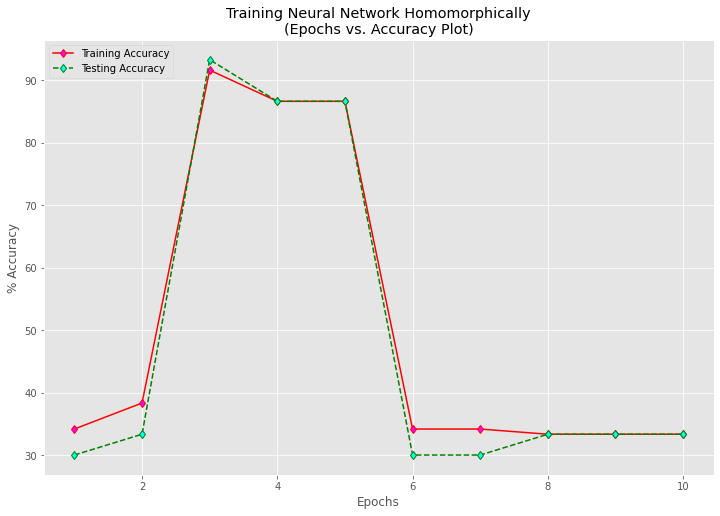

In [8]:
from matplotlib import pyplot as plt

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12, 8)

plt.plot(range(1, len(training_accuracy_list) + 1), training_accuracy_list, marker='d', markerfacecolor='magenta', color='red', linestyle='solid', label='Training Accuracy')
plt.plot(range(1, len(testing_accuracy_list) + 1), testing_accuracy_list, marker='d', markerfacecolor='cyan', color='green', linestyle='dashed', label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')
plt.title('Training Neural Network Homomorphically\n(Epochs vs. Accuracy Plot)')
plt.legend(loc='upper left')
plt.show()